# 2. Feature Engineering

In this notebook we will transform (scale/normalize,encode categorical features, feature cross) features, create new features and check feature importance.

**Note**: In ML a feature is an independent variable that act as input to the model/system. In our case, features are measured variables that describe the weather/air quality and are stored as columns of a Data Frame.

At the end of this notebook we will have the data ready to start training a ML model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataframe

In [2]:
df = pd.read_feather(path="EDA_dataframe.feather")
print(df.head())

             Datetime  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO  \
0 2013-03-01 00:00:00  2013      3    1     0    9.0   9.0  3.0  17.0  300.0   
1 2013-03-01 01:00:00  2013      3    1     1    4.0   4.0  3.0  16.0  300.0   
2 2013-03-01 02:00:00  2013      3    1     2    7.0   7.0  NaN  17.0  300.0   
3 2013-03-01 03:00:00  2013      3    1     3    3.0   3.0  5.0  18.0    NaN   
4 2013-03-01 04:00:00  2013      3    1     4    3.0   3.0  7.0   NaN  200.0   

     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  
0  89.0  -0.5  1024.5 -21.4   0.0  NNW   5.7  
1  88.0  -0.7  1025.1 -22.1   0.0   NW   3.9  
2  60.0  -1.2  1025.3 -24.6   0.0  NNW   5.3  
3   NaN  -1.4  1026.2 -25.5   0.0    N   4.9  
4  84.0  -1.9  1027.1 -24.5   0.0  NNW   3.2  


## Encode Categorical Feature - Wind direction

The variable **wd** represents wind direction, and normally is divided into 16 categories:N, NNE, NE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, and W.

In our case (in this dataset), the authors thought it was a good idea to group these 16 categories into major 4 categories:
1.NW:
WNW, NW, and NNW. This means, we divide the 360º into 16 slices obtaining the 16 cardinal directions. In order to transform this variable into a numerical variable I decided to divide the full 360º into 16 sections of 22.5º each, and assign each slice to the respective category. The end result is the following:

1. **0º     - North (N)**
2. **22.5º  - North-Northeast (NNE)**
3. **45º    - NorthEast (NE)**
4. **67.5º  - East-Northeast (ENE)**
5. **90º    - East (E)**
6. **112.5º - East-Southeast (ESE)**
7. **135º   - Southeast (SE)**
8. **157.5º - South-Shoutheast (SSE)**
9. **180º   - South (S)**
10. **202.5º- South-Southwest (SSW)**
11. **225º  - Southwest(SW)**
12. **247.5º- West-Southwest (WSW)**
13. **270º  - West (W)**
14. **292.5º- West-Northwest (WNW)**
15. **315º  - Northwest (NW)**
16. **337.5º- Nort-Northwest (NNW)**

wd
E      3564
ENE    3861
ESE    2706
N      1865
NE     3540
NNE    1928
NNW    1693
NW     2466
S      1547
SE     1880
SSE    1402
SSW    1953
SW     2481
W       984
WNW    1347
WSW    1769
Name: wd, dtype: int64


<AxesSubplot: >

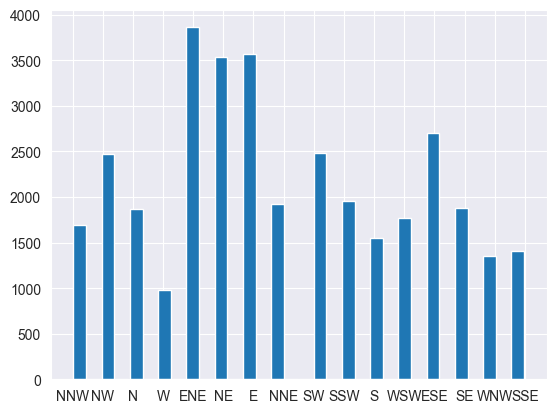

In [3]:
print(df.groupby("wd")["wd"].count())
df["wd"].hist(rwidth=0.9,bins=32)

In [4]:
#putting it into code

wind_dict = {"N":0,
             "NNE":22.5,
             "NE":45,
             "ENE":67.5,
             "E":90,
             "ESE":112.5,
             "SE":135,
             "SSE":157.5,
             "S":180,
             "SSW":202.5,
             "SW":225,
             "WSW":247.5,
             "W":270,
             "WNW":292.5,
             "NW":315,
             "NNW":337.5
             }

df["wd"] = df["wd"].replace(wind_dict).astype(float)

In [5]:
print(df["wd"].unique())
print(df.groupby("wd")["wd"].count())

[337.5 315.    0.  270.   67.5  45.   90.   22.5 225.  202.5 180.  247.5
 112.5 135.  292.5 157.5   nan]
wd
0.0      1865
22.5     1928
45.0     3540
67.5     3861
90.0     3564
112.5    2706
135.0    1880
157.5    1402
180.0    1547
202.5    1953
225.0    2481
247.5    1769
270.0     984
292.5    1347
315.0    2466
337.5    1693
Name: wd, dtype: int64


## Dealing with Missing Values





As we've seen in the EDA notebook we have some missing values, but overall less than 10% per variable.

There are many strategies when dealing with missing values: filling with the mean/mode/median, delete entries when data is missing, using the last available value, or even linear,polynomial, or spline interpolation.

I experimented with spline interpolation but decided to use **Random Forest Regression** in the end, because it offered the best results and had the right balance between simplicity/complexity and performance.
Random Forest Regression was easy to build using sklearn **IterativeImputer** which is a multivariate imputer (multivariate missing value filler) that estimates each feature from all others. Using Random Forest means we build *n* decision trees to estimate the missing values and compute the average across the *n* predictions to obtain the final predicted missing values.

**Note**: Simpler filling methods like mean/mode/median or last available value would work reasonably well if we only had 1-5 missing values at a time. In our case, in variables **CO** and **NO2** we have large blocks of missing values of around 1000 entries each. I wouldn't be a good idea to fill those blocks all with the same value, and deleting them would result in a big loss of information as well.




<AxesSubplot: >

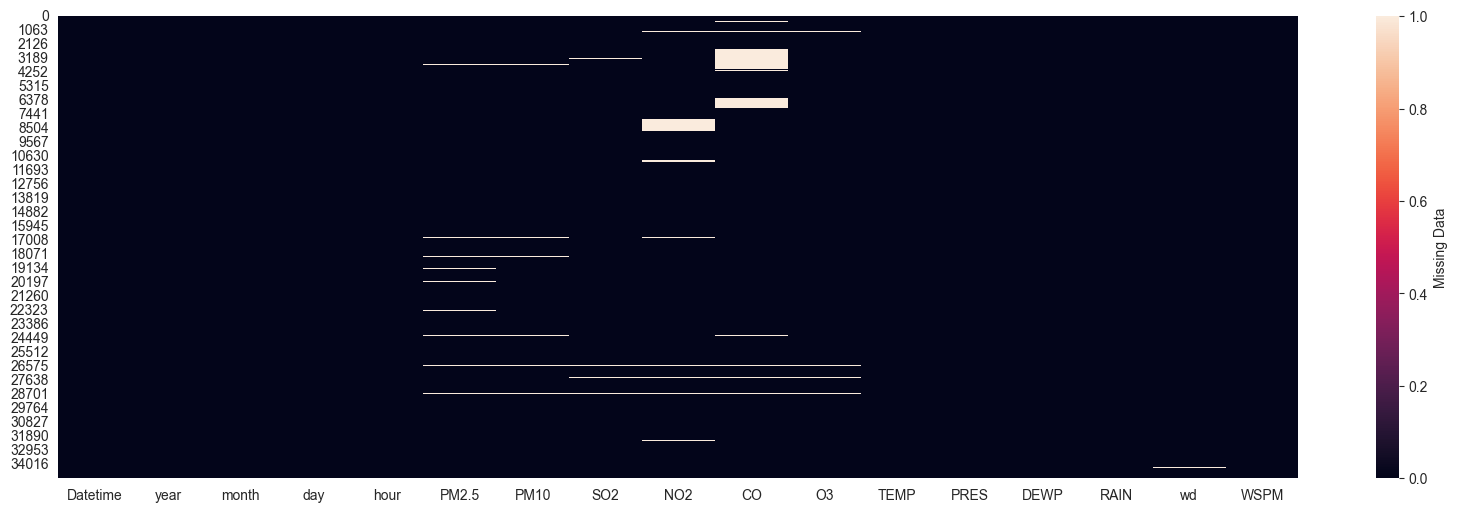

In [6]:
#Plotting the missing values, notice thew big blocks
plt.figure(figsize=(20,6))
sns.heatmap(df.isna(),cbar_kws={'label': 'Missing Data'})

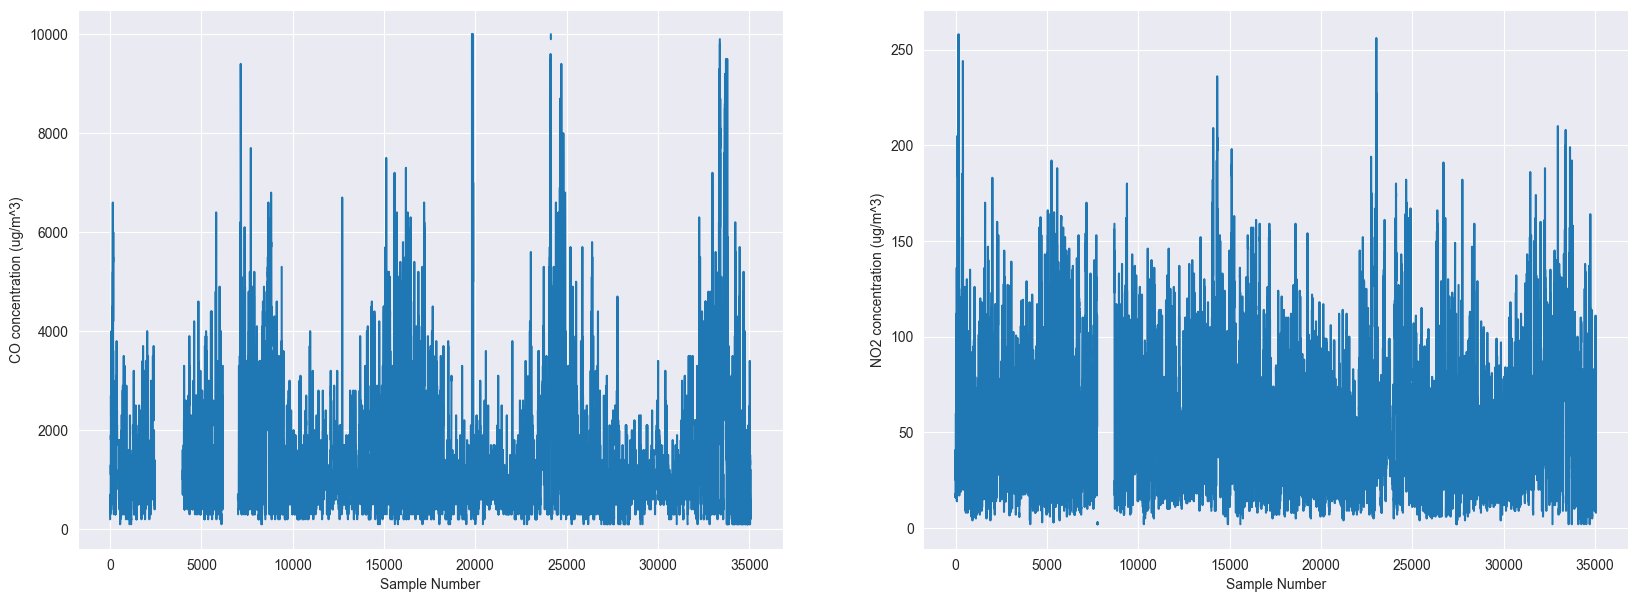

In [7]:
#plot the variables with more missing values, notice the big chunks of data missing
fig,ax = plt.subplots(1,2,figsize=(20,7))
df["CO"].plot(ax=ax[0])
ax[0].set_xlabel("Sample Number")
ax[0].set_ylabel("CO concentration (ug/m^3)")
df["NO2"].plot(ax=ax[1])
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("NO2 concentration (ug/m^3)")
plt.show()

In [15]:
#Imputing the missing data using sklearn IterativeImputer with RandomForestRegressor as estimator

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

#remove categorical features and keep numerical/continual features
cont_df = df.drop(columns=["Datetime"])
cont_feats = [col for col in cont_df.columns]
print(cont_feats)
mins_values = cont_df.min().to_numpy()
print(len(cont_feats),mins_values.shape)

#estimator - RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=10,max_depth=20,bootstrap=True,max_samples=0.8,n_jobs=2,random_state=42)

tolerance=1e-2
#build imputer object
imputer = IterativeImputer(random_state=42,estimator=estimator,max_iter=25,tol=tolerance,min_value=mins_values)
#fill the missing values
imputed_values = imputer.fit_transform(cont_df[cont_feats])
#build a complete (with 0 missing values) df
df_iter_inputed = pd.DataFrame(imputed_values,columns=cont_feats)

['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']
16 (16,)


D:\Mlops_Air\venv\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Let's see the results of the imputation in the variables that had the most missing values:

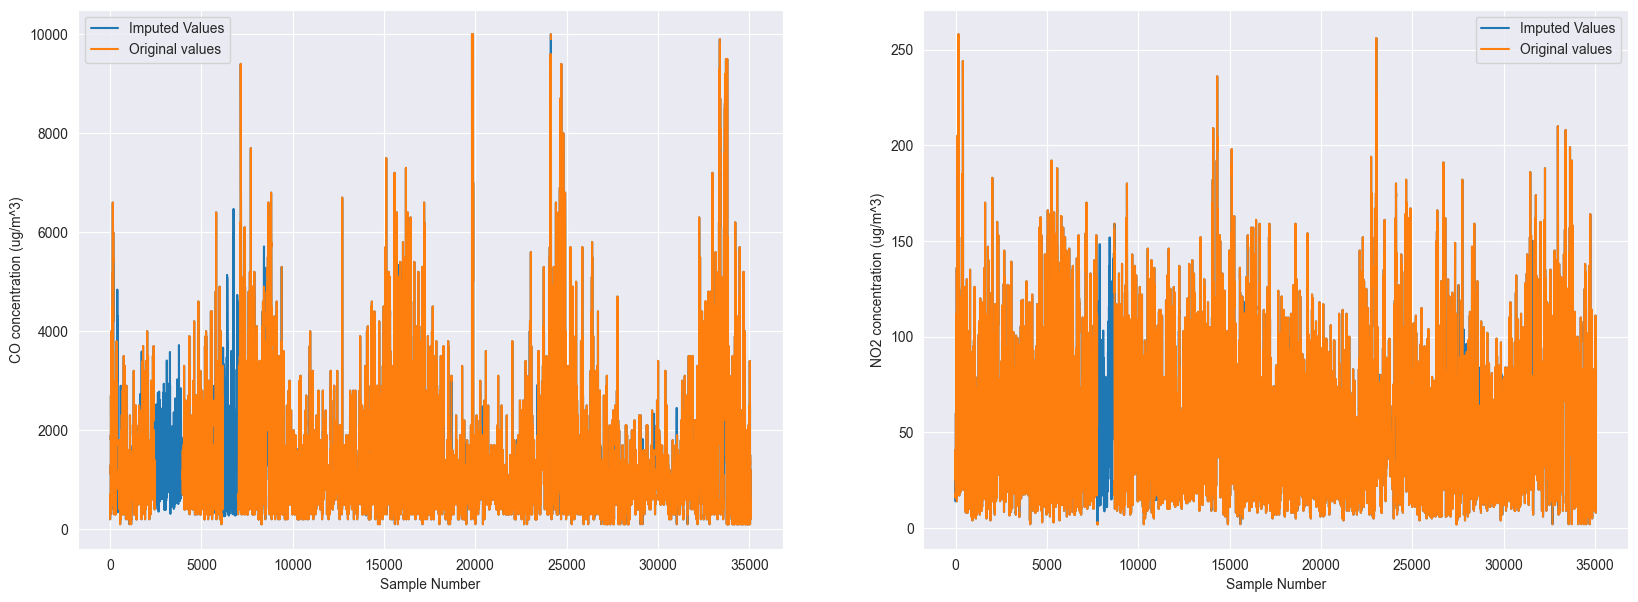

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(df_iter_inputed["CO"].to_numpy(),label="Imputed Values")
ax[0].plot(df["CO"].to_numpy(),label="Original values")
ax[0].set_xlabel("Sample Number")
ax[0].set_ylabel("CO concentration (ug/m^3)")
ax[0].legend()

ax[1].plot(df_iter_inputed["NO2"].to_numpy(),label="Imputed Values")
ax[1].plot(df["NO2"].to_numpy(),label="Original values")
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("NO2 concentration (ug/m^3)")
ax[1].legend()
plt.show()


(35064, 1)
(35064, 16)
(35064, 17)


<AxesSubplot: >

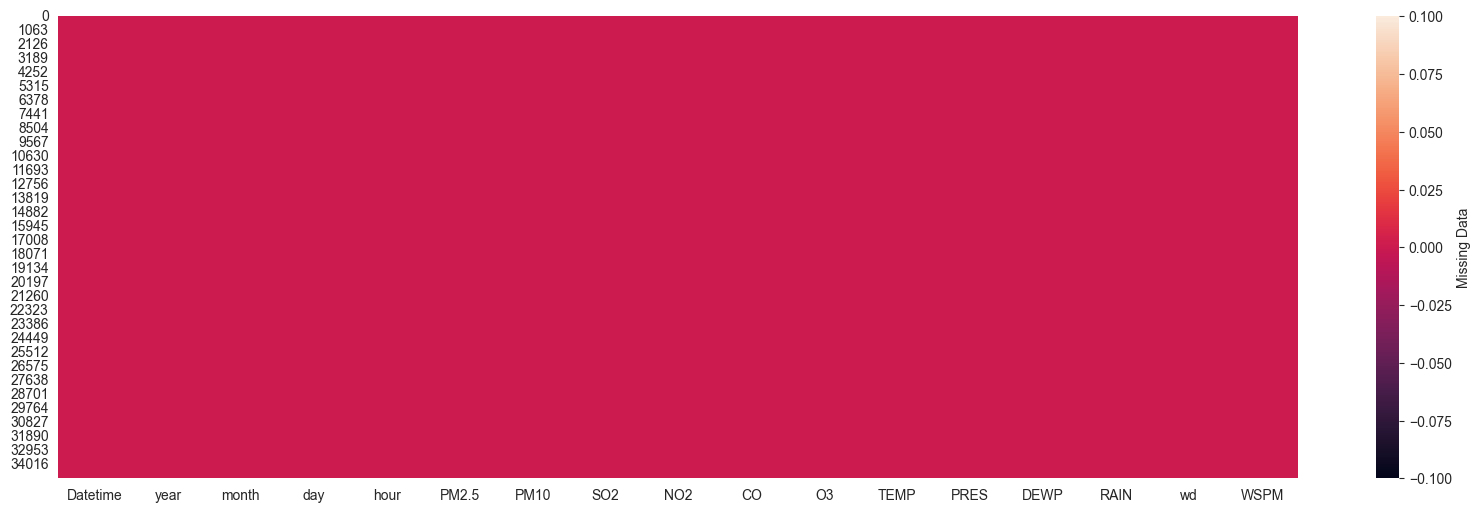

In [17]:
cat_df = df[["Datetime"]]
print(cat_df.shape)
print(df_iter_inputed.shape)

complete_df = pd.concat([cat_df,df_iter_inputed],axis=1)
print(complete_df.shape)

plt.figure(figsize=(20,6))
sns.heatmap(complete_df.isna(),cbar_kws={'label': 'Missing Data'})

We can see that the missing values are gone. We are now ready to start transforming each feature.

We will start by dealing with date related variables

## Feature Transformation

## Date related features

For now we have 3 date related columns: Datetime, Year, Month, Day, Hour. The Datetime column is redundant and only serves as an auxiliary tool.

We can add more columns to complete the information we already have:
1. Weekend or Holiday?[binary] --> Weekends and Holidays should influence the amount of air pollution (less commute--> less traffic--> less pollution)
2. Day of the Week[1,7] --> Air pollution should be related to the day of week
3.
